## Data == Music
-------------
A predictive model that can predict how highly rated 
music will be based on audio characteristics and 
track information from Spotify!

Here's what we're in for

* Define X and y
* Instantiate a classifier
* Fit the model to the data
* Predict and evaluate model accuracy
* others that I don't remember right now

In [95]:
# Import and set up ALL THE THINGS!

import numpy as np
import pandas as pd
import pprint
pp = pprint.PrettyPrinter(depth=4)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.color_palette("muted")
sns.set_style("ticks", {'axes.grid': False,
                        'axes.linewidth': 0.5,
                       }
             )

from sklearn import metrics
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor

from DataEqualsMusic import SpotiAPI

Let's recall the steps to making machine learning models:
1. Create a feature matrix and response vector (X and y)
2. Import an estimator class
3. Instantiate that estimator class
4. Fit the model with training data
5. Use the model to predict a new observation
6. Evaluate the model's accuracy
7. ???
8. PROFIT!

We'll be following steps 1-6, then you're on your own.

First things first, let's get our data from a .csv into a DataFrame.
(FYI, you can update the .csv file by running DataEqualsMusic.py.)

In [47]:
file = "data/modified_spotify_top_200.csv"
df = pd.read_csv(file)

# Here's what our data's top 3 rows look
df.head(3)

,Unnamed: 0,Position,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode
0,0,1,0.798,0.156,92.943,0.0432,0.0736,0.00000,4.0,0.608,6.0,185352.0,-5.092,0.488,0.0
1,1,2,0.524,0.111,95.010,0.0338,0.4140,0.00000,4.0,0.748,8.0,244960.0,-5.599,0.635,1.0
2,2,3,0.718,0.122,199.864,0.0576,0.0784,0.00001,4.0,0.476,8.0,205947.0,-5.309,0.143,1.0


## 1. Create a feature matrix and response vector (X and y)

In [48]:
# Our feature columns are all of them after "Position", which is our response variable.
feature_cols = df.columns[2:]

X = df[feature_cols]
y = df.Position

Before we really dig in, let's try to visualize any potential relationships in the data.

Are there any overall trends we can see right off the bat?

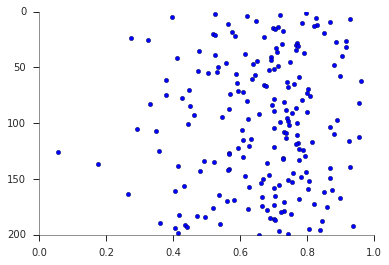

In [99]:
# Let's see if a scatter plot shows us anything.
plt.scatter(df["energy"], y)

# Set axis limits: energy 0.0 - 1.0, Position 1 - 200
plt.axis((0.0,1.0,0,200))

# Invert the y axis, we want high ranking to be on top.
plt.gca().invert_yaxis()

# Vanity
sns.despine()

plt.show()

At least we can see that most of the top 200 tracks tend to be fairly energetic. Let's see where most of them are relative to the others.

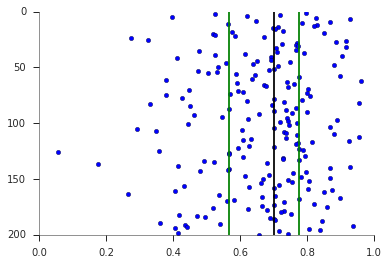

In [104]:
e = df.energy
p_25 = np.percentile(e, 25) # Returns 25th percentile of the "energy" feature
p_50 = np.percentile(e, 50) 
p_75 = np.percentile(e, 75)

# Same plot as before, plus lines for the percentiles
plt.scatter(df["energy"], y)
plt.axis((0.0,1.0,0,200))
plt.gca().invert_yaxis()
sns.despine()

# Just so we can see them, let's give the lines some colors
plt.axvline(x=p_25, color="Green")
plt.axvline(x=p_50, color="Black")
plt.axvline(x=p_75, color="Green")

plt.show()

In [106]:
print p_25, p_50, p_75

0.567 0.7 0.77425


Well well! From this we can see that most tracks are pretty energetic, like we thought. 

The median energy level is 0.7, which about the norm for artists like Selena Gomez and David Guetta.

In [ ]:
# Let's try the same for danc
g = sns.lmplot("danceability", 'Position', df)
g.set(ylim=(0, 200))

In [ ]:
That's something! Looks like songs that aren't very energetic

import numpy as np


In [ ]:
g = sns.lmplot(x="key", y='Position', data=df)
g.set(ylim=(0, 200))

In [ ]:
g = sns.lmplot(x="valence", y='Position', data=df)
g.set(ylim=(0, 200))
g.set(xlim=(0, 1.0))

In [ ]:
# column_names = ["Position", "energy", "liveness", "tempo", "speechiness", "acousticness", "instrumentalness", "time_signature", "danceability", "key", "duration_ms", "loudness", "valence", "mode"]
sns.lmplot(x="tempo", y='Position', data=df)

In [ ]:
# Let's look closer at one in particular to keep an eye on.



In [ ]:
# Find out most predictive feature with correlation matrix


In [ ]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
# Let's take a look at the shape of our data.
print X.shape # 200,14. Makes sense; 200 rows and 14 features.
print y.shape # 200,

print X_train.shape # 150, 14
print X_test.shape # 50, 14
print y_train.shape # 150,
print y_test.shape # 50,

It is at this point that I attempted to make a logistic regression model, fit it to the data, and make predictions with it. 

However, that turned out to be incredibly non-predictive so I scrapped it. 

Unfortunately, I didn't keep a copy for posterity so we're just going to move on to a model that should perform better: RandomForestRegressor!

In [ ]:
# Moment of truth; let's see how accurate our logistic regression model is at predicting a track's Position


In [ ]:
# We can probably do better, let's tune the model a bit and see where that gets us.



In [ ]:
# Let's try with a more thorough model using a Random Forest Classifier.


# calculate cross-validated AUC

# cv=3
score = cross_val_score(logreg, X, y, scoring='roc_auc').mean()
print score



# Gauge accuracy (with simple metrics for now)

# make prediction for testing dataset, then check its accuracy.
y_pred_class = logreg.predict(X_test)
print metrics.accuracy_score(y_test, y_pred_class)

# calculate AUC
print metrics.roc_auc_score(y_test, y_pred_prob)

In [ ]:
#create and train the random forest
#multi-core CPUs can use: rf = RandomForestClassifier(n_estimators=100, n_jobs=2)
rf = RandomForestClassifier(n_estimators=100)

X_train, X_test, y_train, y_test
rf.fit(train, target)